In [ ]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # use CPU only
from jax import config
config.update("jax_enable_x64", True)  # float64 globally
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
print(jax.__version__) # My jax version is 0.8.1
print(matplotlib.__version__) # My matplotlib version is 3.10.6

0.8.1
3.10.6


In [ ]:
# ------------------------
# Objective & gradient
# ------------------------
def objective(w):
    x1, x2 = w
    return (x1 + 1) ** 2 * (x2 + 1) ** 2 + jnp.exp(
        -((x1**2 + 1) ** (1 / 8)) - (x2**2 + 1) ** (1 / 8)
    )

value_and_grad = jax.value_and_grad(objective)

# ------------------------
# Runner factory
# ------------------------

def make_gd_runner(K: int, alpha: float, save_every: int | None = None):
    if save_every is None:
        save_every = max(K // int(1e8), 1)

    # We *do* precompute sample_indices; this is at most ~1e8 entries.
    sample_indices = jnp.arange(0, K, save_every, dtype=jnp.int64)

    @jax.jit
    def run(w0: jnp.ndarray):
        num_points = sample_indices.size
        dim = w0.size

        def step(carry, _):
            w, saved, save_idx, i = carry
            _, grad = value_and_grad(w)
            w_next = w - alpha * grad

            # Decide whether to save w_next at this step
            do_save = (save_idx < num_points) & (i == sample_indices[save_idx])

            def save_branch(args):
                w_, saved_, idx_, i_ = args
                saved_ = saved_.at[idx_].set(w_)
                return w_, saved_, idx_ + 1, i_

            def no_save_branch(args):
                return args

            w2, saved2, save_idx2, i2 = jax.lax.cond(
                do_save,
                save_branch,
                no_save_branch,
                (w_next, saved, save_idx, i),
            )

            # Increase loop index
            return (w2, saved2, save_idx2, i2 + 1), None

        init_saved = jnp.zeros((num_points, dim), dtype=w0.dtype)
        init_carry = (w0, init_saved, jnp.int32(0), jnp.int64(0))

        # No jnp.arange(K) here; we only specify length=K
        (w_final, saved_points, _, _), _ = jax.lax.scan(
            step,
            init_carry,
            xs=None,
            length=K,
        )
        return w_final, saved_points

    return run, sample_indices

In [ ]:
def add_auto_magnifier(ax, last_frac=0.5, inset_size=(0.35, 0.25), margin_frac=0.05):
    """
    Add a magnifier inset to `ax` for the last `last_frac` of the FIRST line's data.

    - Call this *after* you have plotted your main trajectory on `ax`.
    - If you don't call it, the plot is unchanged.
    """

    # Use the first line on this axis
    line = ax.lines[0]
    x = jnp.asarray(line.get_xdata())
    y = jnp.asarray(line.get_ydata())
    n = x.size

    # ----- 1) last `last_frac` portion -----
    start = max(int((1.0 - last_frac) * n), 0)
    x_last = x[start:]
    y_last = y[start:]

    # Zoom region in data coords, padded a bit
    xmin = jnp.min(x_last)
    xmax = jnp.max(x_last)
    ymin = jnp.min(y_last)
    ymax = jnp.max(y_last)

    spanx = float(xmax - xmin)
    spany = float(ymax - ymin)
    if spanx == 0.0:
        spanx = 1.0
    if spany == 0.0:
        spany = 1.0

    xmin = float(xmin) - margin_frac * spanx * 2
    xmax = float(xmax) + margin_frac * spanx * 2
    ymin = float(ymin) - margin_frac * spany * 10
    ymax = float(ymax) + margin_frac * spany * 10

    inset_w, inset_h = inset_size

    # ----- 3) Create inset & plot inside -----
    axins = ax.inset_axes([0.55, 0.55, inset_w, inset_h])

    # axins.plot(x, y, color=color, linewidth=lw)
    axins.plot(x, y, "yo", markersize=2)
    axins.set_xlim(xmin, xmax)
    axins.set_ylim(ymin, ymax)

    # Style: grey background, blue frame, no ticks (like your picture (2))
    edgecolor = "tab:blue"
    facecolor = "#f0f0f0"

    axins.set_facecolor(facecolor)
    for sp in axins.spines.values():
        sp.set_edgecolor(edgecolor)
        sp.set_linewidth(1.0)

    axins.set_xticks([])
    axins.set_yticks([])
    axins.tick_params(bottom=False, left=False)

    # ----- 4) Connectors + shaded ROI on main axes -----

    xmin = jnp.min(x_last)
    xmax = jnp.max(x_last)
    ymin = jnp.min(y_last)
    ymax = jnp.max(y_last)

    indicator = ax.indicate_inset(
        bounds=(
            xmin - 0.025 * (xmax - xmin),
            ymin - 0.15 * ymax * (ymax - ymin),
            1.05 * (xmax - xmin),
            0.45 * ymax * (ymax - ymin),
        ),
        inset_ax=axins,
        edgecolor="blue",
        facecolor="grey",
        alpha=0.25,
    )

    # Matplotlib ≥3.10: single artist with .rectangle / .connectors
    if hasattr(indicator, "rectangle") and hasattr(indicator, "connectors"):
        rect = indicator.rectangle
        connectors = indicator.connectors
    else:
        # older Matplotlib: (rect, connectors) tuple
        rect, connectors = indicator

    rect.set_facecolor("0.9")
    rect.set_alpha(0.3)

    # connectors may be None / a single artist / a list/tuple
    if connectors is None:
        conn_iter = []
    elif isinstance(connectors, (list, tuple)):
        conn_iter = connectors
    else:
        conn_iter = [connectors]

    for c in conn_iter:
        c.set_color(edgecolor)
        c.set_alpha(0.4)
        c.set_linewidth(1.0)

    return axins

In [ ]:
def plot_contour(trajectory, w0, alpha):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.plot(
        trajectory[:, 0],
        trajectory[:, 1],
        "yo",
        markersize=1,
        alpha=0.6,
        label="Marker Trajectory",
    )

    ax.plot(
        w0[0],
        w0[1],
        "ro",
        markersize=8,
        markerfacecolor="r",
        label=f"Initial Point ({w0[0]:.1f}, {w0[1]:.1f})",
    )

    # add-on: call this line to get the magnifier
    add_auto_magnifier(ax, last_frac=0.1)

    ax.set_xlabel(r"$x_1$", fontsize=18, fontweight="bold")
    ax.set_ylabel(r"$x_2$", fontsize=18, fontweight="bold")
    ax.set_title(
        f"GD Trajectory (Step size = {alpha:.2g})", fontsize=16, fontweight="bold"
    )
    ax.grid(True, linestyle="--", alpha=0.7)

    plt.show()
    fig.savefig("fig1.png", dpi=300)

Initial point w0: [-0.98128909  0.03826571]
K, alpha: 4000000000 0.0001
saved indices: (100000000,) trajectory shape: (100000000, 2)


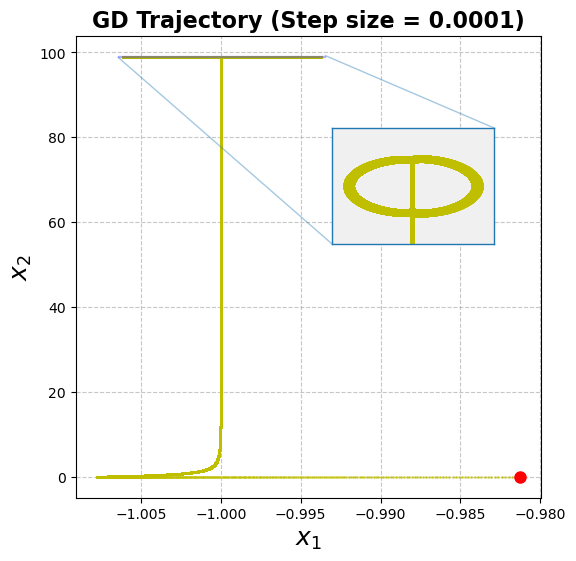

In [ ]:
# ------------------------
# Example usage
# ------------------------

key = jax.random.key(100)
w0 = jax.random.normal(key, (2,), dtype=jnp.float64)
print("Initial point w0:", w0)

## Try three different step sizes, as step sizes decrease, you need more steps to see the oscillations.

# K, alpha = 1 * 10**6, 1e-2
# K, alpha = 5 * 10**7, 1e-3 # This takes <1 minute.
K, alpha = 4 * 10**9, 1e-4  # This takes ~9 minutes.

run, idx = make_gd_runner(K, alpha)
w_final, traj = run(w0)
print("K, alpha:", K, alpha)
print("saved indices:", idx.shape, "trajectory shape:", traj.shape)
plot_contour(traj, w0, alpha)